In [106]:
%matplotlib inline
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston

from sklearn.preprocessing import OneHotEncoder

import numpy as np
import tensorflow as tf

sns.set(style="ticks", color_codes=True)

In [107]:
dataset = load_boston()
houses = pd.DataFrame(dataset.data, columns=dataset.feature_names)
houses['target'] = dataset.target

In [108]:
# WRITE CODE TO CONVERT 'TARGET' COLUMN FROM CONTINUOUS TO CATEGORICAL
mean = np.mean(dataset.target)
lengthOfTarget = len(dataset.target)
i = 0
while i < lengthOfTarget:
    if dataset.target[i] > mean:
        houses.target.set_value(i,1)
    else:
        houses.target.set_value(i,0)
    i = i+1

In [109]:
'''check your work'''
print np.max(houses['target']), "<-- should be 1"
print np.min(houses['target']), "<-- should be 0"

1.0 <-- should be 1
0.0 <-- should be 0


In [110]:
houses_array = houses.as_matrix().astype(float)
np.random.shuffle(houses_array)

X = houses_array[:, :-1]
y = houses_array[:, -1]

#one hot encoding
y=y.reshape(-1,1)
enc=OneHotEncoder()
enc.fit(y)

y=enc.transform(y).toarray()

X = X / X.max(axis=0)

trainingSplit = int(.9 * houses_array.shape[0])
X_train = X[:trainingSplit]
y_train = y[:trainingSplit]
X_test = X[trainingSplit:]
y_test = y[trainingSplit:]

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

('Training set', (455, 13), (455, 2))
('Test set', (51, 13), (51, 2))


In [111]:
print y_train.shape[1], "<-- should be 2"
print y_test.shape[1], "<-- should be 2"
print y_train[0], "<-- should be either [0. 1.] or [1. 0.]"

2 <-- should be 2
2 <-- should be 2
[ 0.  1.] <-- should be either [0. 1.] or [1. 0.]


In [112]:
# helper variables
num_samples = X_train.shape[0]
num_features = X_train.shape[1]
num_outputs = y_train.shape[1]

# Hyper-parameters
batch_size = 18
num_hidden_1 = 32
num_hidden_2 =  30
learning_rate =  0.1
training_epochs =  500
dropout_keep_prob = 0.9 # 0.5 # set to no dropout by default

# variable to control the resolution at which the training results are stored
display_step = 1

In [113]:
def accuracy(predictions, targets):
    
    # IMPLEMENT THE NEW ACCURACY MEASURE HERE
    max_pred = np.argmax(predictions,1)
    max_target = np.argmax(targets,1)
    accuracy = (np.sum((max_pred == max_target))/float(max_pred.shape[0]))*100.00
    return accuracy

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


In [114]:
graph = tf.Graph()

with graph.as_default():
    
    x = tf.placeholder(tf.float32, shape=(None, num_features))
    _y = tf.placeholder(tf.float32, shape=(None))
    
    keep_prob = tf.placeholder(tf.float32)
    
    tf_X_test = tf.constant(X_test, dtype=tf.float32)
    tf_X_train = tf.constant(X_train, dtype=tf.float32)
    
    
    W_fc1 = weight_variable([num_features, num_hidden_1])
    b_fc1 = bias_variable([num_hidden_1])
    
    W_fc2 = weight_variable([num_hidden_1, num_hidden_2])
    b_fc2 = bias_variable([num_hidden_2])
    
    W_fc3 = weight_variable([num_hidden_2, num_outputs])
    b_fc3 = bias_variable([num_outputs])
    
    
    def model(data, keep):
        
        fc1 = tf.nn.sigmoid(tf.matmul(data, W_fc1) + b_fc1)
        fc1_drop = tf.nn.dropout(fc1, keep)
        
        fc2 = tf.nn.sigmoid(tf.matmul(fc1_drop, W_fc2) + b_fc2)
        fc2_drop = tf.nn.dropout(fc2, keep)
        
        fc3 = tf.matmul(fc2_drop, W_fc3) + b_fc3
        
        return fc3
    
    '''for our loss function we still want to get the raw outputs 
    of the model, but since it no longer represents the actual prediction 
    we rename the variable to ‘output’'''
    output = model(x, keep_prob)
    
    # WHEN WE CALCULATE THE PREDICTIONS, WE NEED TO WRAP EACH OUTPUT IN A
    # tf.nn.softmax() FUNCTION. THE FIRST ONE HAS BEEN DONE FOR YOU:
    prediction = tf.nn.softmax(output)
    test_prediction = model(tf_X_test, 1.0)
    train_prediction = model(tf_X_train, 1.0)
    
    '''finally, we replace our previous MSE cost function with the
    cross-entropy function included in Tensorflow. This function takes in the
    raw output of the network and calculates the average loss with the target'''
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, _y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    saver = tf.train.Saver()

In [115]:
results = []

with tf.Session(graph=graph) as session:
    
    tf.initialize_all_variables().run()
    print('Initialized')

    for epoch in range(training_epochs):
        
        indexes = range(num_samples)
        random.shuffle(indexes)
        
        for step in range(int(math.floor(num_samples/float(batch_size)))):
            offset = step * batch_size
            
            batch_data = X_train[indexes[offset:(offset + batch_size)]]
            batch_labels = y_train[indexes[offset:(offset + batch_size)]]

            feed_dict = {x : batch_data, _y : batch_labels, keep_prob: dropout_keep_prob}
            
            _, l, p = session.run([optimizer, loss, prediction], feed_dict=feed_dict)

        if (epoch % display_step == 0):
            batch_acc = accuracy(p, batch_labels)
            train_acc =  accuracy(train_prediction.eval(session=session), y_train)
            test_acc =  accuracy(test_prediction.eval(session=session), y_test)
            results.append([epoch, batch_acc, train_acc, test_acc])

    save_path = saver.save(session, "model_houses_classification.ckpt")
    print("Model saved in file: %s" % save_path)

Initialized
Model saved in file: model_houses_classification.ckpt


Maximum test accuracy: 98.04%


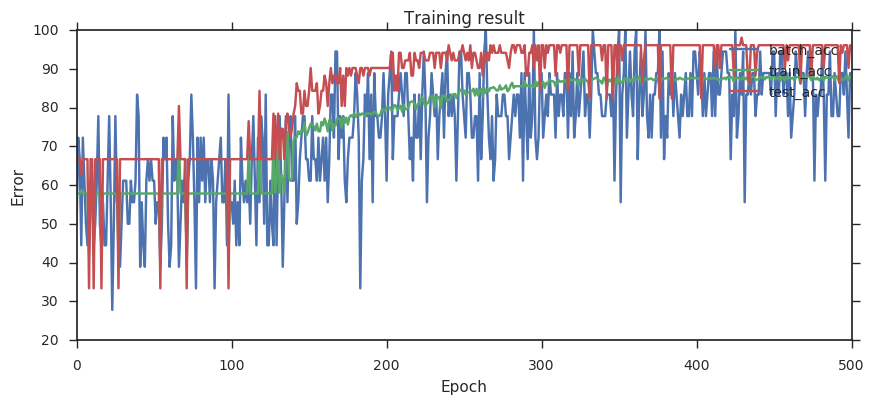

In [116]:
df = pd.DataFrame(data=results, columns = ["epoch", "batch_acc", "train_acc", "test_acc"])
df.set_index("epoch", drop=True, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
 
ax.plot(df)
ax.set(xlabel='Epoch',
       ylabel='Error',
       title='Training result')
 
ax.legend(df.columns, loc=1)

print "Maximum test accuracy: %.2f%%" % np.max(df["test_acc"])